In [1]:
import glob
import numpy as np
from skimage import io
from skimage.transform import rescale
import re
from sklearn.model_selection import train_test_split, learning_curve
from math import sqrt
from sklearn.neural_network import MLPClassifier
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

In [2]:
def get_data():
    files = glob.glob('data/hiragana73/*/*.png')
    m = len(files)
    print('Found %d files.' %m)
    
    return files

In [3]:
def create_data_array(files):
    X = np.array([io.imread(file, as_gray=True) for file in files])
    print('Data array created.')

    return X

In [4]:
def create_target_array(files):
    char_codes = files
    
    # Extract unicode from filepath
    i = 0
    for char_code in char_codes:
        code = re.search(r'[0-9]{3}[0-9A-F]', char_code)
        char_codes[i] = code.group(0)
        i += 1
        
    # Convert unicode to hiragana
    for i in range(len(char_codes)):
        char_codes[i] = chr(int(char_codes[i], 16))
        
    y = np.asarray(char_codes)
    print('Target array created.')
    
    return y

In [5]:
def reduce_dataset(X, y, reduced_size):
    '''
    Returns a stratified subsample of the dataset
    X, y reduced in size by (1 - reduced size).
    Can be used to save CPU time if you only need to
    perform quick experiments on a smaller dataset.
    '''
    
    X_discard, X, y_discard, y = train_test_split(X, y, test_size=reduced_size, stratify=y)
    print('Reduced dataset to %d%% of original size.' %(reduced_size*100))
    
    return X, y

In [6]:
def clean_data(X):
    # Rescaled images need new array
    m = X.shape[0] # Number of examples
    rescale_factor = 0.5
    image_side_new = int(X.shape[1] * rescale_factor)
    X_new = np.zeros(shape=(m, image_side_new, image_side_new))
    
    # Rescale and binarise (make black-and-white)
    for i in range(m):
        image = X[i]
        image = rescale(image, scale=rescale_factor)
        thresh = threshold_otsu(image)
        image = image > thresh
        X_new[i] = image        
        
    # Flatten for sklearn
    X_new = X_new.reshape(m, -1)
    
    print('Data cleaned.')
    
    return X_new

In [7]:
def train_and_test(X, y, n_folds):
    print('Training and testing classifier with %d folds...' %n_folds)
    
    # Set up classifier
    input_layer_size = X.shape[1]
    output_layer_size = len(set(y))
    hidden_layer_size = int(sqrt(input_layer_size*output_layer_size))

    clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,),
                        max_iter=300)

    # Train/test
    train_fractions = np.array([1/16, 1/8, 1/4, 1/2, 1])
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf, X=X, y=y, train_sizes=train_fractions,
        cv=n_folds, scoring='accuracy', shuffle=True)
    
    return train_sizes, train_scores, test_scores

In [8]:
def evaluate(train_sizes, train_scores, test_scores):
    print('Classifier performance:')
    
    train_acc_means = np.mean(train_scores, axis=1)
    train_acc_errs = 2*np.std(train_scores, axis=1)

    test_acc_means = np.mean(test_scores, axis=1)
    test_acc_errs = 2*np.std(test_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_acc_means, 'k--', label='Train accuracy')
    if np.sum(train_acc_errs) > 0:
        plt.fill_between(train_sizes, train_acc_means-train_acc_errs,
                         train_acc_means+train_acc_errs,
                         color='lightgray', alpha=0.5)
    plt.plot(train_sizes, test_acc_means, 'k-', label='Test accuracy')
    plt.fill_between(train_sizes, test_acc_means-test_acc_errs,
                     test_acc_means+test_acc_errs, color='lightgray',
                     alpha=0.5, label='± 2σ')
    plt.xlabel('Number of training examples (log scale)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xscale('log')
    plt.xlim(train_sizes[0], train_sizes[-1])
    plt.xticks(train_sizes, train_sizes)
    plt.minorticks_off()
    plt.legend(loc='lower right', fontsize=12)
    plt.title('Learning curves', fontsize=16)
    plt.show()
    
    # Final results (with full dataset)    
    print('Final results ± 2σ:')
    print('    train accuracy: (%.2f ± %.2f)%%,'
          %(train_acc_means[-1]*100, train_acc_errs[-1]*100))
    print('    test accuracy: (%.2f ± %.2f)%%.\n'
          %(test_acc_means[-1]*100, test_acc_errs[-1]*100))

In [ ]:
def run():
    files = get_data()
    X = create_data_array(files)
    y = create_target_array(files)
    #X, y = reduce_dataset(X, y, reduced_size=0.1)
    X = clean_data(X)
    train_sizes, train_scores, test_scores = train_and_test(X, y, n_folds=5)
    evaluate(train_sizes, train_scores, test_scores)

Found 80000 files.
Data array created.
Target array created.
Data cleaned.
Training and testing classifier with 5 folds...
Classifier performance:


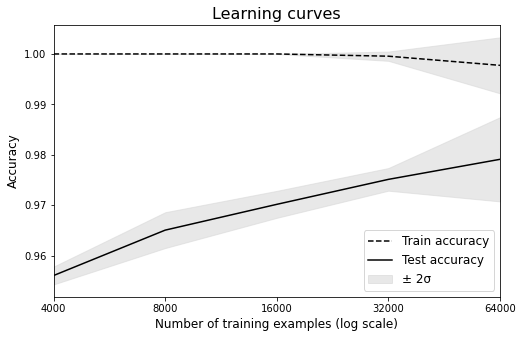

Final results ± 2σ:
    train accuracy: (99.77 ± 0.55)%,
    test accuracy: (97.91 ± 0.83)%.



In [ ]:
run()

## Possible imrpovements:

* The learning curves suggest we could get a better result if we have more data. We would either have to collect more real data, or create artificial data via augmentation. Beware the x-axis is a log scale, so another doubling of data means doubling the CPU time needed to train. Anything less than a doubling will bring very modest improvements to accuracy.

* Optimise hyperparamaters, e.g. using a grid search.

* Different/further pre-processing of the data (see `explore.ipynb`) might allow us to engineer/extract some useful features to train on.

We should also consider that we're already achieving ~98% accuracy. Any further gains will be small, so depending on the application, we should consider whether the value of any future gains are worth the time required to achieve them.